## This is a proof-of-concept to clean up a noisy sinusoidal signal using ML algorithm.


### First we import all necessary libraries

In [243]:
%matplotlib inline
import numpy as np
from numpy.random import seed
from numpy.random import randn
import matplotlib.pyplot as plt
import random

### Then change the default display settings for the plots

In [244]:
plt.rc('figure', figsize=(12,6))

### Generate and plot the sinusoidal signal

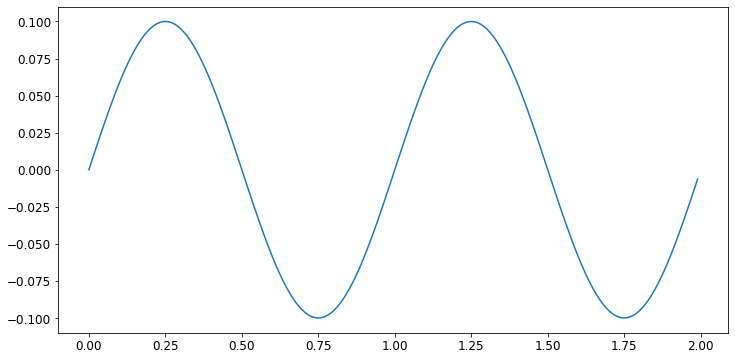

In [245]:
dt = 0.01
t = np.arange(0, 2, dt)
s = 0.1 * np.sin(2 * np.pi * t) 
plt.plot(t,s)
plt.show()

### Add noise to the signal and plot

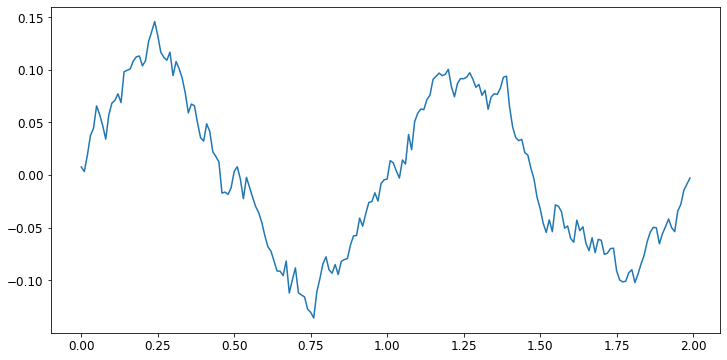

In [246]:
nse = randn(len(t))
r = np.exp(-t / 0.05)
cnse = np.convolve(nse, r) * dt
cnse = cnse[:len(t)]
s = 0.1 * np.sin(2 * np.pi * t) + cnse
plt.plot(t,s)
plt.show()

### Then label the x and y axis and add a title

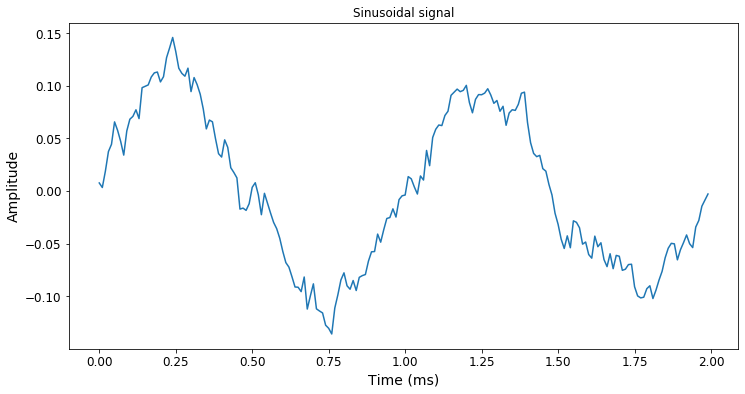

In [247]:
plt.plot(t,s)
plt.ylabel("Amplitude")
plt.xlabel("Time (ms)")
plt.title("Sinusoidal signal")
plt.show()

### Generating the noisy signal datasets

In [248]:
def generate_datasets(n_samples):
    '''
    This generates the datasets for x and y values of the sinusoidal signal. 
    It returns an array corresponding to the x and y values of the clean signal,
    and the noisy signal. The inner array contains three elements:
        index 0 refers to the time(x axis).
        index 1 refers to the amplitude of the noisy signal(y axis), and 
        index 2 refers to the amplitude of the clean signal(y axis).
    The number of datasets generated is specified by the argument n_samples.
    The returned array is of shape [samples[time,noisy signal, clean signal]].
    '''

    batch_sig = []
    batch_y = []
    
    # Fixing random state for reproducibility
    seed(42)

    for _ in range(n_samples):
        dt = 0.01
        amplitude = 0.1
        t = np.arange(0, 2, dt)

        nse = randn(len(t))
        r = np.exp(-t / 0.05)
        cnse = np.convolve(nse, r) * dt
        cnse = cnse[:len(t)]
        s = 0.1 * np.sin(2 * np.pi * t)
        s_cnse = 0.1 * np.sin(2 * np.pi * t) + cnse

        sig_ = np.array([t, s_cnse, s])

        sig_ = sig_.T

        batch_sig.append(sig_)

    #batch_sig = np.array(batch_sig)

    return batch_sig

### Getting 3 sets of data (clean and noisy)

In [249]:
some_data = generate_datasets(3)

## Plotting the clean and noisy signal

In [250]:
def plot_signals(data):
    for _ in range(len(data)):
        if _ == 0:
            plt.plot(data[_].T[0], data[_].T[2], '--', label = 'Clean Signal ')

        plt.plot(data[_].T[0], data[_].T[1], label = 'Noisy Signal Number ' + str(_+1))
        plt.ylabel("Amplitude")
        plt.xlabel("Time (ms)")
        plt.title("Sinusoidal signal")
        plt.legend(loc = 'lower left')
    plt.show()

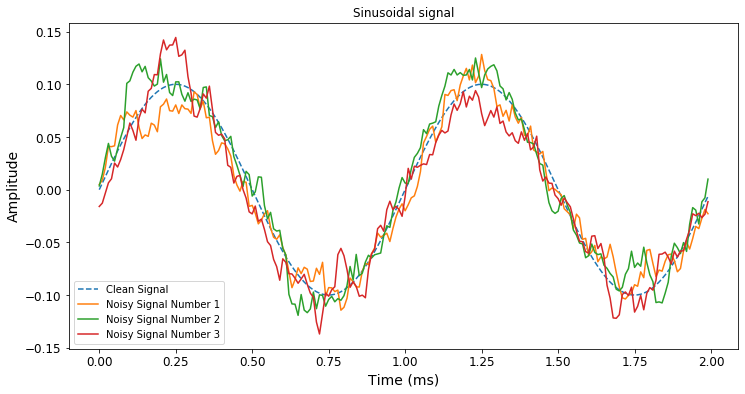

In [251]:
plot_signals(some_data)